**Lab 6: IIR Filtering**


The objective for this lab is to build an intuitive understanding of the relationship between the location
of poles and zeros in the z-domain, the impulse response h[n] in the n-domain, and the frequency
response $H(e^{j\omega})$. We use the system function,
represented as a ratio of polynomials in $z^{-1}$, which can be expressed in either factored or expanded form as:

$$
H(z) = G\frac{\prod_{k=1}^M (1-z_kz^{-1}) }{\prod_{k=1}^N (1-p_kz^{-1})} = \frac{ \sum_{k=0}^M b_kz^{-k}}{ 1- \sum_{k=1}^N a_kz^{-k} }
$$

In [1]:
!git clone https://github.com/pzinemanas/sis1lab.git

import numpy as np
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

from sis1lab.util import load_audio, plot_signals, plot_spectrogram, plot_frequency_response, save_audio

Cloning into 'sis1lab'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 59 (delta 16), reused 28 (delta 6), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [2]:
!git clone https://github.com/JamesBedsonUPF/sis1_group9.git
filepath = "./sis1_group9/HarpSound.wav"
ref, fs = load_audio(filepath)

Cloning into 'sis1_group9'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 4), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (14/14), done.


**1. IIR filters to extract the envelope**

In the previous labs, you extracted the envelope from your reference signal by applying the following system:

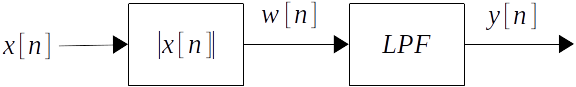

where $w[n] = |x[n]|$ and $y[n]$ was the output of a low-pass FIR filter (averaging filter). In this exercise, you will re-implement this low-pass filter as an IIR.

1.1 First, copy the functions envelope and synthesize from previous work and obtain the same synthesis. 



In [3]:
# Write your code here
def averaging_filter(x, N, mode):
  b_k = [1/N]*N
  y = np.convolve(b_k, x, mode)
  return y

def synthesize(f0, phi, Ak, t):
  y = 0
  for k in range(1, len(Ak) + 1):
    y += Ak[k-1] * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)
  return y

def envelope(x, N):
  abs_x = np.abs(x)
  y = averaging_filter(abs_x, N, "same")
  return y 

In [4]:
envelope_signal = envelope(ref, 500)
Ts = 1/float(fs)
t = np.arange(0, len(envelope_signal)*Ts, Ts)
t1 = 0.1004771
frequency = 1071.277
period = 1 / frequency
start = 0.1
rad_frequency = 2 * np.pi * frequency
our_phi = - rad_frequency * t1
weights = [1, 0.11245, 0.008772, 0.01561, 0.001569, 0.0012267, 0.000644, 0.0006886015, 0.000566, 0.000487, 0.000531]
synthesized_signal = synthesize(frequency, our_phi, weights, t)
#synthesized_signal = (weights[1] * synthesized_signal-0.001) / np.amax(synthesized_signal)

multiplied = synthesized_signal * envelope_signal

In [5]:
plot_signals([ref, multiplied], fs, name=['reference', 'synthesised'])

1.2 Let's take a look at the following system:

$$
H(z) = G\frac{1+z^{-1}}{1-rz^{-1}} \quad   0<r<1 \quad, G = \frac{1-r}{2}
$$

Note that the coefficients of the filter are the following:

$$
b_0 = 1, \quad b_1 = 1, \quad a_0 = 1, \quad a_1 = -r, \quad
$$

i. Find the zeros and poles of the system analytically.

Zeros: $1+z^{-1} = 0 \rightarrow z+1=0 = \rightarrow z=-1$

Poles: $1-rz^{-1} = 0 \rightarrow z - r = 0 \rightarrow z = r$ 

ii. Use the function `np.roots` to find the zeros and poles using Python. Compare the results with part i.

In [6]:
# Write your code here
r = 0.3
zeros = np.roots([1, 1])
poles = np.roots([1, -r])

print(zeros)
print(poles)

[-1.]
[0.3]


iii. Use the function  `plot_zeros_poles(z, p)` to plot the zeros and poles found in ii.

In [7]:
from sis1lab.util import plot_zeros_poles

# Write your code here
plot_zeros_poles(zeros, poles)


1.3 Let's see the frequency response of this filter:



In [8]:
ww = np.arange(-np.pi, np.pi, np.pi/500)
r = 0.9
G = (1 - r)/2
_, HH = signal.freqz([G, G], [1, -r], ww)

plot_frequency_response(ww, HH)

1.4. Change the parameter $r$ in the range $(0, 1)$. What happens when $r$ is increased?

As r increases, we have seen in the plots that the range of frequencies that 
get cancelled is higher. 

1.5 What type of filter is (low-pass, band-pass, or high-pass filter)?


It is a low-pass filter, since it attenuates high frequencies.

1.6 Now we can use this IIR filter to extract the envelope. Let's define a new function `envelope_iir(x)` that applies the filter to the absolute value of the signal. Note that we are using signal.lfilter function to apply the filter.


In [9]:
def envelope_iir(x, r=0.995):
  G = (1 - r)/2
  y = signal.lfilter([G, G], [1, -r], np.abs(x))
  return y

Extract the envelope of your reference signal using both the FIR and IIR filters and compare the results plot them along with the signal. Change the value of $r$ until you are comfortable with the result.

In [10]:
# Write your code here
iir_envelope = envelope_iir(ref)

plot_signals([ref, iir_envelope, envelope_signal], fs, name=['reference', 'iir', 'fir'])


Output hidden; open in https://colab.research.google.com to view.

1.7 What are the main differences between the two filters? For instance, compare the number of coefficients.

Graphically, both filters are quite similar. We can see that the envelope generated by the IIR filter is more accurate in terms of following the shape of the reference signal (we can see it quite clearly at the beginning). 
As for the coefficients, the FIR uses 500 whereas the IIR uses only 4.

1.8 Apply the new envelope (extracted from the IIR filter) to the synthesis generated with the `synthesize` function and listen to the result.

In [ ]:
# Write your code here
multiplied_iir = synthesized_signal * iir_envelope

plot_signals([ref, multiplied_iir], fs, name=['reference', 'multiplied'])

ipd.Audio(multiplied_iir, rate=fs)


---

**2. Band-pass filters**

Now let's work with the following system: 

$$
H(z) = \frac{(1-z^{-1})(1+z^{-1})}{(1-re^{j\omega_n}z^{-1})(1-re^{-j\omega_n}z^{-1})}, \quad 0<r<1
$$

Note that the poles are $p_1 = re^{j\omega_n}$ and $p_2 = re^{-j\omega_n}$; and the zeros are $z_1=1$ and $z_2=-1$. 

2.1 Use the function `plot_zeros_poles` to plot the zeros and poles of the system.

Note: use $w_n = \pi/4$ and $r=0.99$.

In [ ]:
# Write your code here

plot_zeros_poles([1, -1], [0.99 * np.exp(1j*np.pi/4), 0.99 * np.exp(-1j*np.pi/4)])

2.2 Show analytically that $a_k = [1, -2rcos(\omega_n), r^2]$ and $b_k=[1, 0, -1]$.

$(1-z^{-1})\cdot(1+z^{-1}) = 0 \rightarrow 1 + z^{-1} - z^{-1}-z^{-2} = z^2-1$, therefore $b_k = [1, 0, -1]$

$(1-re^{j\omega_n}z^{-1})\cdot(1-re^{-j\omega_n}z^{-1})\rightarrow 1 - r e^{j \omega_n}z^{-1} - r e^{-j \omega_n}z^{-1} + r^2 z^{-2}\rightarrow 1 - 2r\cos(\omega_n)z^{-1} + r^2 z^{-2}\rightarrow z^2 -2r\cos(\omega_n)z + r^2$, therefore $a_k = [1, -2r\cos(\omega_n)+ r^2]$

2.3 Plot the frequency response of the filter. Confirm this is a band-pass filter. What's the central frequency of the passband?

In [ ]:
# Write your code here
ww = np.arange(-np.pi, np.pi, np.pi/500)
r = 0.99
G = 1
_, HH = signal.freqz([1, 0, -1], [1, -2*r*np.cos(np.pi/4), r**2], ww)

plot_frequency_response(ww, HH)


We can clearly see in the plot of the frequency response that this is a band-pass filter, because it boosts middle frequencies and attenuates both low and high frequencies.
The central frequency of the band pass is $\frac{\pi}{4}$.




2.4 Define a function `bpf(x, f, r, fs)` that applies the above band-pass filter. 

Note 1: remember that a frequency can be converted to the normalized radian frequncy by: $\omega_n = 2\pi f_n/f_s$.

Note 2: use `signal.lfilter` function to implement the filter.

In [ ]:
def bpf(x, fn, fs, r=0.995):
  """Applies a band-pass filter with central frequency fn

  Parameters
  ----------
  x : np.array
      The input signal in the form of a numpy array
  fn: int or float
      Central frequency of the band pass in Hz 
  fs : int or float
      Frequency rate in Hz
  r: float
      Magnitude of the poles

  Returns
  -------
  y : np.array
      The output of the filter

  """
  # Write your code here
  normalised_freq = 2*np.pi*fn/fs
  y = signal.lfilter([1, 0, -1], [1, -2*0.99*np.cos(normalised_freq), 0.99**2], x)
  return y

2.5 Regardless of the phase, until now we were synthesizing the instrument signal by summing $K$ harmonics of the signal with different weights ($A_k$) and multiplying the sum by the envelope of the reference signal ($e(t)$):

$$y(t) = e(t) \cdot \sum_{k=1}^K A_k\cos\left(2\pi kf_0 t \right), $$

where $f_0$ is the fundamental frequency of the note. Now we want to improve this synthesis by finding a time-dependent amplitude ($A_k(t)$) for each harmonic:

$$y(t) = \sum_{k=1}^K A_k(t) \cos\left(2\pi kf_0 t \right), $$

where $A_k(t)$ is the amplitude of the harmonic $k$. To extract the amplitudes $A_k(t)$ we'll apply a band-pass filter with central frequency $kf_0$ and calculate the envelope of the output by using the `envelope_iir`.


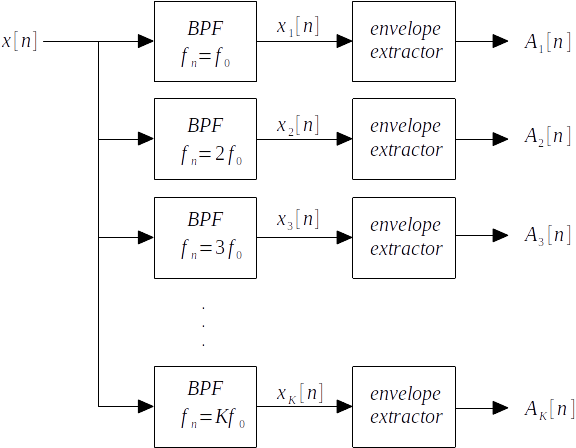

For instance, the following code should extract the envelope of the fundamental frequency component. Change the value of $f_0$ to coincide with your fundamental frequency and check the result. 

In [ ]:
f0 = 1071.277 # put your fundamental frequency here
x_1 = bpf(ref, f0, fs)
A_1 = envelope_iir(x_1, r=0.999)
plot_signals([x_1, A_1], fs, t_start=0, t_end=1.5, name=['x_1(t)', 'A_1(t)'])

2.6 Complete the `synthetize_with_bpf` function to implement a synthesis applying different envelopes for each harmonic.


In [ ]:
def synthetize_with_bpf(x, f0, phi, K, fs):
  """Synthetizes an harmonic signal using different envelopes for each harmonic
  The envelops are extracted from the reference signal x.

  Parameters
  ----------
  x : np.array
      The reference signal in the form of a numpy array
  f0: int or float
      Fundamental frequency of the synthesis
  phi : float
      Phase
  K: int
      Number of harmonics
  fs : int or float
      Frequency rate in Hz

  Returns
  -------
  y : np.array
      The output of the filter

  """
  Ts = 1/float(fs)
  t = np.arange(0, len(x)*Ts, Ts)

  y = 0
  for k in range(1, int(K) + 1):
    x_k = bpf(x, k * f0, fs)
    A_k = envelope_iir(x_k)
    y += A_k * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)

  y = np.amax(x)*y/np.amax(y) # normalize the output
  return y

2.6 Call the function `synthetize_with_bpf` to get the synthesized signal and **listen to it**.

Note that now you can increase the number of harmonics $K$ as you want because we are not manually measuring the weights of each harmonic.

In [ ]:
# Write your code here
bandpass_signal = synthetize_with_bpf(ref, frequency, our_phi, 15, fs)

plot_signals([ref, multiplied_iir, bandpass_signal], fs, t_start=0, t_end=1.5, name=['ref', 'multiplied_iir', 'bandpass filter'])
ipd.Audio(bandpass_signal, rate=fs)



In [ ]:
ipd.Audio(ref, rate=fs)

2.7 Compare the **spectrograms** of the synthesized signal and reference signal.

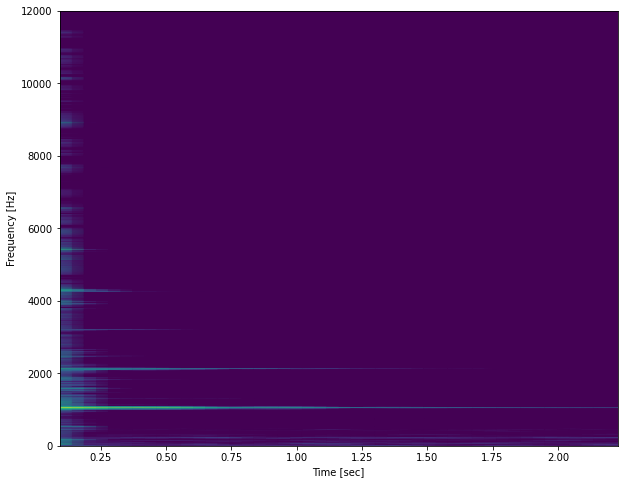

In [ ]:
window_length = 8192
ff, tt, S = signal.spectrogram(ref, fs, nperseg=window_length, noverlap=window_length/2)

plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, S)
plt.ylim([0, 12000])
plt.show()

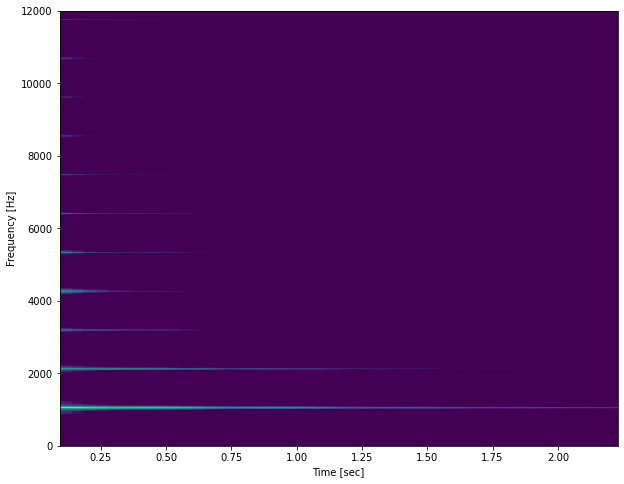

In [ ]:
window_length = 8192
ff, tt, S = signal.spectrogram(bandpass_signal, fs, nperseg=window_length, noverlap=window_length/2)

plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, S)
plt.ylim([0, 12000])
plt.show()